In [1]:
%cd Master_Thesis_MMDE_latest/

c:\Users\kagad\Thesis_implementation\Master_Thesis_MMDE_latest


In [2]:
import os
import glob
import torch
import torch.nn as nn
import cv2
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

from dataset import TrainDataLoader,ValDataLoader

from TransMIRNet import fusion_net

In [3]:
def read_image(path):
    img = cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def load_sparse_depth(input_sparse_depth_fp):
    input_sparse_depth = np.array(Image.open(input_sparse_depth_fp), dtype=np.float32)/256
    return input_sparse_depth

In [ ]:
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 1280
BATCH_SIZE = 1
CROP_SCALE_HEIGHT = 0.4
CROP_SCALE_WIDTH = 0.8

In [5]:
train_transform = A.Compose([
    A.OneOf([
        A.RandomCrop(width=int(IMAGE_WIDTH * CROP_SCALE_WIDTH), height=int(IMAGE_HEIGHT * CROP_SCALE_HEIGHT), p=1),
        A.CenterCrop(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1)
    ], p=1),
    
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Sharpen(p=0.2),
    A.GaussNoise(var_limit=(10, 50),p=0.1),
],
    additional_targets={
        "radar_img": "mask",
        "ground_truth": "mask",
        "mmde_map": "mask"
    }
)

val_transform = A.Compose(
    [
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1),
    ],
    additional_targets={
    "radar_img": "mask",
    "ground_truth": "mask",
    "mmde_map": "mask"
    }
)






In [16]:
import ast
# read from file
file_path = os.path.join("outputs", "mean_depth_dataset.txt")

with open(file_path, mode="r") as f:
    lines = f.readlines()

mean_line = lines[0].split()[1:]
std_line = lines[1].split()[1:]

MEAN = ast.literal_eval(" ".join(mean_line))
STD = ast.literal_eval(" ".join(std_line))

print("Mean:", MEAN)
print("Std:", STD)

Mean: [0.4305, 0.4467, 0.4153]
Std: [0.2429, 0.2342, 0.2411]


In [17]:
image_folder = "../data/image"
mmde_map_path = "../data/mmde_map"
gt_path = "../data/gt_interp"
radar_path ="../data/radar_png"

image_paths = glob.glob(os.path.join(image_folder, '*.*'))
mmde_map = glob.glob(os.path.join(mmde_map_path, '*.*'))
ground_truth_paths = glob.glob(os.path.join(gt_path, '*.*'))
radar_paths = glob.glob(os.path.join(radar_path, '*.*'))

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_image_paths, val_image_paths, train_mmde_map, val_mmde_map, train_radar_paths, val_radar_paths, train_gt_paths, val_gt_paths = train_test_split(
    image_paths, mmde_map, radar_paths, ground_truth_paths, test_size=0.2, random_state=42)

In [18]:
train_dataset = TrainDataLoader(image_paths=train_image_paths,
                                mmde_path = train_mmde_map,
                                radar_paths = train_radar_paths,
                                ground_truth_paths = train_gt_paths,
                                transform=train_transform,
                                mean=MEAN,
                                std=STD)

val_dataset = ValDataLoader(image_paths=val_image_paths,
                            mmde_path = val_mmde_map,
                            radar_paths = val_radar_paths,
                            ground_truth_paths = val_gt_paths,
                            transform=val_transform,
                            )

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=0)


In [20]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=0)

In [21]:
image, mmde, radar, gt = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7400447..2.4251347].


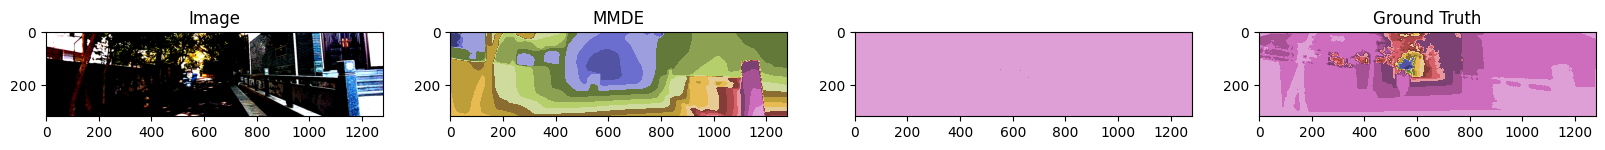

In [22]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.imshow(image[0].permute(1, 2, 0), cmap='tab20b')
plt.title("Image")
plt.subplot(1, 4, 2)
plt.imshow(mmde[0].permute(1, 2, 0), cmap='tab20b')
plt.title("MMDE")
plt.subplot(1, 4, 3)
plt.imshow(radar[0].permute(1, 2, 0), cmap='tab20b')
plt.subplot(1, 4, 4)
plt.imshow(gt[0].permute(1, 2, 0), cmap='tab20b')
plt.title("Ground Truth")
plt.show()

In [26]:
class Params:
    def __init__(self):
        self.radar_input_channels = 1
        self.encoder_radar = 'resnet18'
        self.mmde_encoder = "resnet18"
        self.activation = 'elu' # why?
        self.encoder = 'resnet34'
        self.max_depth = 4
params = Params()

In [27]:
model = fusion_net(params)

c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-dat

In [29]:
# hyperparameterss
lr = max_lr = 1e-3
weight_decay = 1e-2
num_epochs = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE, type(DEVICE)

(device(type='cuda'), torch.device)

In [30]:
# INFO
num_train_samples = len(train_dataloader.dataset)
num_val_samples = len(val_dataloader.dataset)

num_train_steps = len(train_dataloader)
num_val_steps = len(val_dataloader)

print(f"Number of samples: Train: {num_train_samples} | Val: {num_val_samples}")
print(f"Number of steps: Train: {num_train_steps} | Val: {num_val_steps}")

Number of samples: Train: 14 | Val: 4
Number of steps: Train: 14 | Val: 4


In [31]:
# loss function
from loss import l1_loss

criterial = l1_loss()

# optimizer
optimizer = torch.optim.AdamW(model.parameters(),lr=lr, weight_decay=weight_decay)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr, # max_lr = 1e-3
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    div_factor=10, # initial lr = max_lr/div_factor
    pct_start=0.3, #decay start at 30% of the total epochs
    anneal_strategy='cos' # anneal strategy
)

In [32]:
# # callbacks
# early_stopping = EarlyStopping(patience=20, verbose=True)
# checkpoint = Checkpoint(
#     root_dir="depth_experiment",
#     experiment_name="deph_head",
#     checkpoint_name="model_depth",
#     save_model_only=True
# )

In [33]:
from lightning.fabric import Fabric

torch.set_float32_matmul_precision('medium')

fabric = Fabric(accelerator="gpu", precision="32") # precision = "32" / "16-mixed" / "bf16-mixed"

model, optimizer = fabric.setup(model, optimizer)
train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

In [34]:
from evaluation_ import compute_metrics,display_metrics

In [35]:
import wandb
from tqdm.notebook import tqdm
from prettytable import PrettyTable

In [36]:
wandb.init(project="thesis", config={"learning_rate": scheduler.get_last_lr()[0], "epochs": num_epochs, "batch_size": train_dataloader.batch_size})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vik7086 (vik7086-technische-hochschule-ingolstadt). Use `wandb login --relogin` to force relogin


In [39]:
def train_one_epoch(model, dataloader, optimizer, scheduler, criterion, fabric, epoch, num_steps, mode="train", eval_step=5):
    is_training = (mode == "train")
    if is_training:
      model.train()
    else:
      model.eval()
    prefix = "train" if is_training else "val"

    running_loss = 0.0
    accumulated_metrics = {key: 0.0 for key in ["silog", "abs_rel", "log10", "rms", "sq_rel", "log_rms", "mae", "d1", "d2", "d3"]}
    pbar = tqdm(enumerate(dataloader, start=1), total=num_steps, leave=True)

    for steps, (image, mmde_map, radar_img, ground_truth) in pbar:
        if is_training:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(image, radar_img, mmde_map)
            mask = outputs > 0.01
            loss = criterion(outputs, ground_truth,mask)

            fabric.clip_gradients(model, optimizer, max_norm=2.0, error_if_nonfinite=False)
            # Backward pass and optimization (only if training)
            fabric.backward(loss)
            optimizer.step()

        else:  # Validation mode
            with torch.no_grad():
                outputs = model(image, radar_img, mmde_map)
                mask = outputs > 0.01
                valid_pixels = torch.sum(mask).item()
                #print(f"Number of valid pixels in mask: {valid_pixels}")
                loss = criterion(outputs, ground_truth,mask)

        running_loss += loss.item()
    if is_training:
      scheduler.step()
    final_loss = running_loss / num_steps


    pbar.set_description(f"Epoch: [{epoch}/{num_epochs}]")
    pbar.set_postfix({f"{prefix}_loss": final_loss, "lr": scheduler.get_last_lr()[0]})

    wandb.log({f"{prefix}_epoch_loss": final_loss, "epoch": epoch})

    return final_loss

In [40]:
# Main training loop with wandb integration
start_epoch = 1

for epoch in range(start_epoch, 100 + 1):
    # Training Phase
    train_loss = train_one_epoch(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterial,
        fabric=fabric,
        epoch=epoch,
        num_steps=len(train_dataloader),
        mode="train"
    )

    # Validation Phase
    val_loss = train_one_epoch(
        model=model,
        dataloader=val_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterial,
        fabric=fabric,
        epoch=epoch,
        num_steps=len(val_dataloader),
        mode="val",
        eval_step=5  # Adjust eval_step as needed
    )

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

        # Log epoch results to wandb
    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch})

        # Early stopping and checkpoint logic
    # early_stopping(val_loss)
    # if early_stopping.save_current_checkpoint:
    #     checkpoint(epoch, train_loss, val_loss, model, optimizer, scheduler)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered. Ending training.")
    #     break

# Finish the wandb run
wandb.finish()

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Train Loss = 5.6504, Validation Loss = 192.3713


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: Train Loss = 5.3543, Validation Loss = 196.2631


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: Train Loss = 5.1474, Validation Loss = 260.4362


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: Train Loss = 4.8109, Validation Loss = 279.0897


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.3793, Validation Loss = 262.2200


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.1961, Validation Loss = 324.9269


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.1127, Validation Loss = 283.6064


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: Train Loss = 4.8635, Validation Loss = 340.3813


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.0280, Validation Loss = 285.1107


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Train Loss = 4.0101, Validation Loss = 312.3729


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: Train Loss = 3.7251, Validation Loss = 267.7428


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: Train Loss = 4.1064, Validation Loss = 342.1148


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: Train Loss = 4.1627, Validation Loss = 328.5126


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: Train Loss = 3.6730, Validation Loss = 314.1256


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Train Loss = 3.3947, Validation Loss = 295.8911


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: Train Loss = 3.8600, Validation Loss = 315.3279


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: Train Loss = 3.9881, Validation Loss = 280.8095


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: Train Loss = 3.0026, Validation Loss = 260.9529


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: Train Loss = 3.0551, Validation Loss = 270.9722


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: Train Loss = 6.8028, Validation Loss = 262.8994


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: Train Loss = 7.7643, Validation Loss = 236.4192


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: Train Loss = 7.3273, Validation Loss = 315.8620


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: Train Loss = 3.4505, Validation Loss = 284.7664


  0%|          | 0/14 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 350.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.84 GiB is allocated by PyTorch, and 557.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [25]:
from tqdm.notebook import tqdm
def train(mode, epoch, dataloader, num_steps, eval_step = 5):
    if mode == "train":
        model.train()
        prefix = "train"
    else:
        model.eval()
        prefix = "val"
    
    running_loss = 0.0
    accumulated_metrics = {
                            "silog": 0.0, "abs_rel": 0.0, "log10": 0.0, 
                            "rms": 0.0, "sq_rel": 0.0, "log_rms": 0.0, 
                            "mae": 0.0, "d1": 0.0, "d2": 0.0, "d3": 0.0
                        }
    
    pbar = tqdm(enumerate(dataloader, start=1), total=num_steps, leave=True)

    for steps, (image, radar_img, ground_truth, mmde_map) in pbar:

        if mode == "train":
            depth_map = model(image, radar_img, mmde_map)
            mask = depth_map > 0.01
            loss = criterial(depth_map, ground_truth, mask)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        elif mode == "val":
            with torch.no_grad():
                depth_map = model(image, radar_img, mmde_map)
                mask = depth_map > 0.01
                loss = criterial(depth_map, ground_truth, mask)

                if epoch == eval_step:
                    batch_metrics = compute_errors_batches(ground_truth, depth_map)
                        
                    for key in accumulated_metrics.keys():
                        accumulated_metrics[key] += batch_metrics[key]      

        
        running_loss += loss.item()
    for key in accumulated_metrics.keys():
            accumulated_metrics[key] /= num_steps
    from prettytable import PrettyTable
    # Create a PrettyTable to display metrics
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]

    # Populate the table with averaged error metrics
    for metric, value in accumulated_metrics.items():
        table.add_row([metric, f"{value:.4f}"])

    # Print the table
    print(table)
    #if steps == num_steps:
    final_loss = running_loss / num_steps
    pbar.set_description(f"Epoch:[{epoch}/{num_epochs}]")
    pbar_postfix_dict = {f"{prefix}_loss": final_loss,
                        "lr": scheduler.get_last_lr()[0]}
    
    pbar.set_postfix(pbar_postfix_dict)

    return final_loss


In [45]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/depth_estimation_experiment")

In [ ]:
for epoch in range(1, num_epochs + 1):

    train_loss = 0.0
    val_loss = 0.0
    num_val_batches = 0

    for i, (image, radar_img, mmde_map, ground_truth) in enumerate(train_dataloader):

        optimizer.zero_grad()

        # Forward pass
        depth_map = model(image, radar_img, mmde_map)
        mask = depth_map > 0.01
        loss = criterial(depth_map, ground_truth, mask)

        # Backward pass and optimization
        fabric.backward(loss)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        writer.add_scalar("Train_Loss/Batch", loss.item(), epoch * len(train_dataloader) + i)

    for i, (image, radar_img, mmde_map, ground_truth) in enumerate(val_dataloader):
        if epoch % 2 == 0:
            with torch.no_grad():
                depth_map = model(image, radar_img, mmde_map)
                mask = depth_map > 0.01
                val_loss_batch = criterial(depth_map, ground_truth, mask).item()
                val_loss += val_loss_batch
                writer.add_scalar("Val_Loss/Batch", val_loss_batch, epoch * len(val_dataloader) + i)

    # Average train loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Average validation loss (if calculated)
    if epoch % 2 == 0:
        avg_val_loss = val_loss / num_val_batches
    else:
        avg_val_loss = None  # Keep the validation loss undefined for this epoch

    # Logging to TensorBoard
    writer.add_scalar("Train_Loss/Epoch", avg_train_loss, epoch)
    if avg_val_loss is not None:
        writer.add_scalar("Val_Loss/Epoch", avg_val_loss, epoch)

    # Print epoch summary
    if avg_val_loss is not None:
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")
    else:
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Validation Loss = Not Calculated")

writer.close()

        


    

In [ ]:
start_epoch = 1

for epoch in range(start_epoch, num_epochs + 1):
    train_loss = train(
        mode="train",
        epoch=epoch,
        dataloader=train_dataloader,
        num_steps=num_train_steps,
        eval_step=5
    )

    val_loss = train(
        mode="val",
        epoch=epoch,
        dataloader=val_dataloader,
        num_steps=num_val_steps,
        eval_step=5
    )

    print(f"epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")

    early_stopping(val_loss)
    if early_stopping.save_current_checkpoint:
        checkpoint(epoch, train_loss, val_loss, model, optimizer, scheduler)

    if early_stopping.early_stop:
        break
    

In [27]:
# Initialize a dictionary to store accumulated errors
total_errors = {key: 0.0 for key in ["silog", "abs_rel", "log10", "rms", "sq_rel", "log_rms", "mae", "d1", "d2", "d3"]}

# Iterate through the ground truth and predicted depth maps
for dep, pred in zip(depth, pred_depth):
    # Compute errors for the current pair of ground truth and prediction
    errors = compute_errors(dep, pred)
    
    # Accumulate errors
    for key, value in errors.items():
        total_errors[key] += value

# Average the errors by dividing by the number of samples
num_samples = len(depth)  # Assuming `depth` and `pred_depth` have the same length
total_errors = {key: value / num_samples for key, value in total_errors.items()}